## Imports

In [22]:
import re
import logging
import warnings
import plotly
import numpy as np
import pandas as pd
import sweetviz as sv
import seaborn as sns


from config import config
from get_offers_by_city import connect
from pandas_profiling import ProfileReport

## NB configs

In [23]:
warnings.filterwarnings('ignore')

SEED = 43

%matplotlib inline
%pylab inline

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['font.size'] = 18

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.expand_frame_repr', False)

sns.set()

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot

pd.options.display.max_rows = 300
pd.options.display.max_columns = 50

Populating the interactive namespace from numpy and matplotlib


## Helper functions

In [24]:
# Function to plot values upside the barplot
def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(float(p.get_height())), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

## Load Data

In [25]:
df = pd.read_csv('../data/all_offers_infos_pp.csv')

In [26]:
df.head()

,offer_id,extraction_date,lat,lng,area_m2,furnished,zip_code,main_category,rooms,build_year,state,city,sub_category,balcony,heat_type,offer_title,kitchen,rent_price,garden
0,45678593,2021-11-10 05:15:08,50.101680,8.658270,65.00,1,60327.0,Wohnung,3.0,1903.0,Hessen,Frankfurt am Main,Etagenwohnung,0,Zentralheizung,* frisch renovierte 3 Zimmerwohnung * Innensta...,0,790.0,0
1,45809669,2021-11-10 05:15:08,51.110890,13.896730,61.00,1,1454.0,Wohnung,3.0,NaN,Sachsen,Radeberg,Wohnung,0,NaN,ALLES NEU ... gemütliches Familien-Nest in grü...,0,410.0,0
2,45842440,2021-11-10 05:15:08,50.099711,8.599638,89.70,1,60326.0,Wohnung,3.0,2016.0,Hessen,Frankfurt am Main,Etagenwohnung,1,NaN,3-Zi.-Wohnung im modernisierten Gallusviertel,0,1350.0,0
3,44924940,2021-11-10 05:15:08,51.044313,13.699018,55.00,1,1159.0,Wohnung,2.0,NaN,Sachsen,Dresden,Etagenwohnung,0,Zentralheizung,Frisch sanierte 2 Raum Wohnung in ruhiger Lage...,0,440.0,0
4,45842445,2021-11-10 05:15:08,53.587650,10.132120,59.55,1,22045.0,Wohnung,3.0,1958.0,Hamburg,Hamburg,Dachgeschosswohnung,0,Zentralheizung,2 1/2 - Zimmer - DG - Mietwohnung,1,685.0,0


## Descritive Analysis

In [29]:
df.shape

(6500, 19)

In [30]:
df.isna().sum()

offer_id              0
extraction_date       0
lat                   0
lng                   0
area_m2             465
furnished             0
zip_code              1
main_category         0
rooms                69
build_year         1279
state                 0
city                  1
sub_category          0
balcony               0
heat_type          2945
offer_title           0
kitchen               0
rent_price           13
garden                0
dtype: int64

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
offer_id,6500.0,4.529343e+07,1.803699e+06,3.069578e+06,4.540550e+07,4.571408e+07,4.581853e+07,4.586725e+07
lat,6500.0,5.116103e+01,1.789777e+00,7.467550e+00,5.012579e+01,5.107268e+01,5.245574e+01,5.399277e+01
lng,6500.0,1.052040e+01,2.481345e+00,6.155846e+00,8.667957e+00,1.001620e+01,1.344623e+01,5.150788e+01
area_m2,6035.0,6.739184e+01,3.318819e+01,8.000000e+00,4.733000e+01,6.235000e+01,8.100000e+01,4.270000e+02
furnished,6500.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
zip_code,6499.0,3.535486e+04,2.742203e+04,1.067000e+03,1.210400e+04,3.016900e+04,6.032900e+04,8.694900e+04
rooms,6431.0,2.459338e+00,1.805604e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.050000e+02
build_year,5221.0,1.978403e+03,5.007240e+01,6.100000e+01,1.956000e+03,1.986000e+03,2.018000e+03,2.133000e+03
balcony,6500.0,3.987692e-01,4.896828e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
kitchen,6500.0,5.043077e-01,5.000199e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   offer_id         6500 non-null   int64  
 1   extraction_date  6500 non-null   object 
 2   lat              6500 non-null   float64
 3   lng              6500 non-null   float64
 4   area_m2          6035 non-null   float64
 5   furnished        6500 non-null   int64  
 6   zip_code         6499 non-null   float64
 7   main_category    6500 non-null   object 
 8   rooms            6431 non-null   float64
 9   build_year       5221 non-null   float64
 10  state            6500 non-null   object 
 11  city             6499 non-null   object 
 12  sub_category     6500 non-null   object 
 13  balcony          6500 non-null   int64  
 14  heat_type        3555 non-null   object 
 15  offer_title      6500 non-null   object 
 16  kitchen          6500 non-null   int64  
 17  rent_price    

                                             |          | [  0%]   00:00 -> (? left)


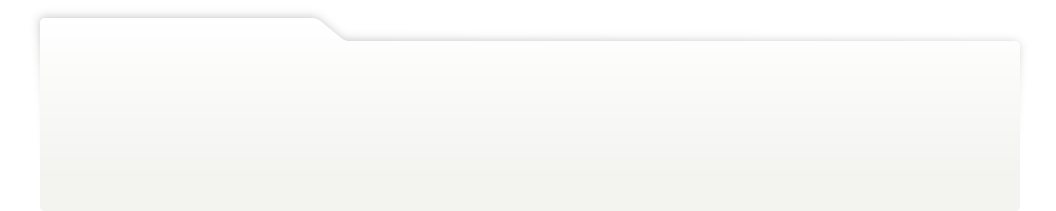
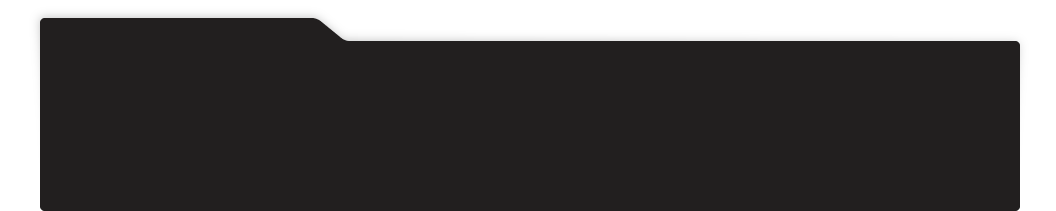
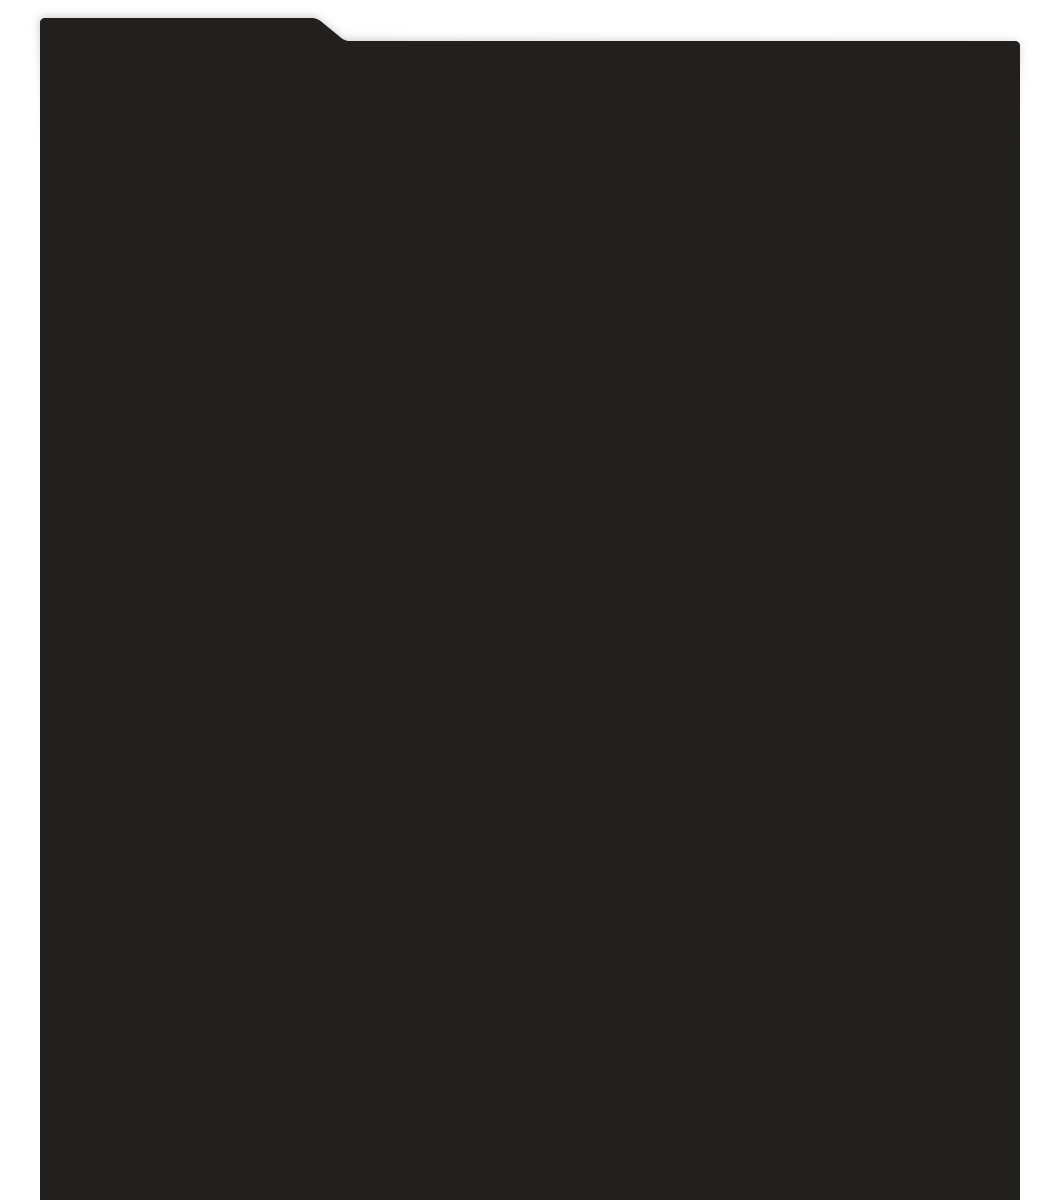
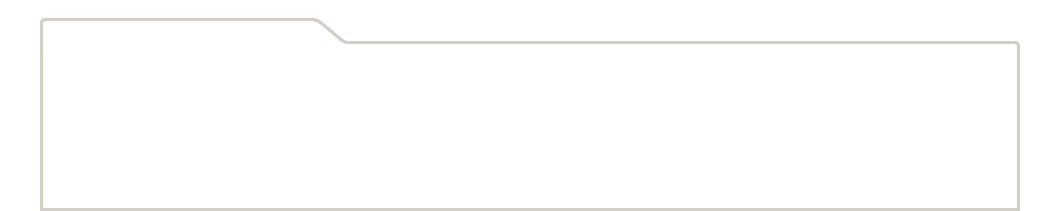
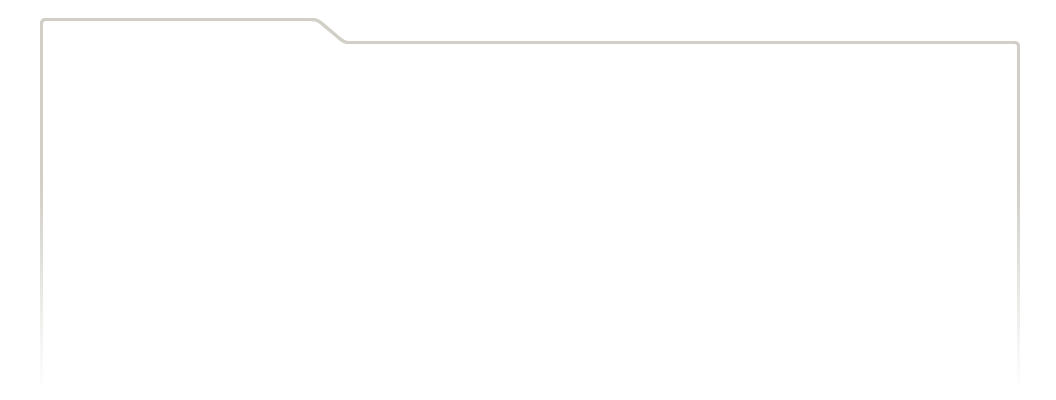
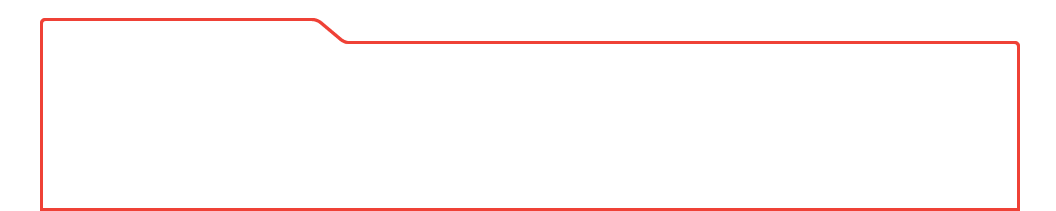
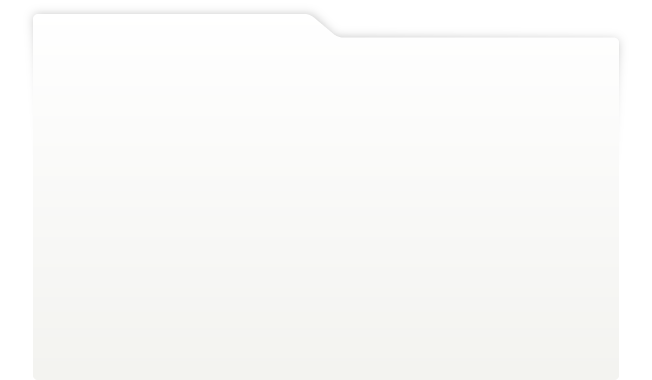
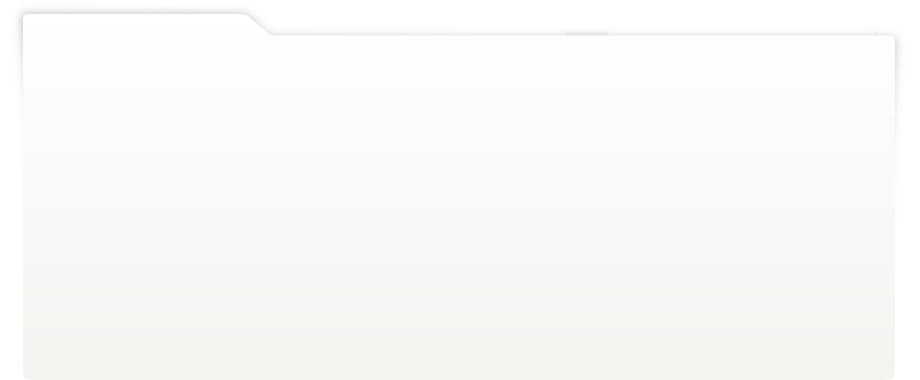
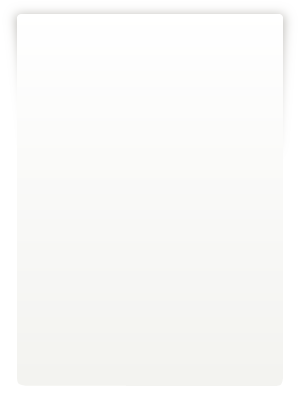
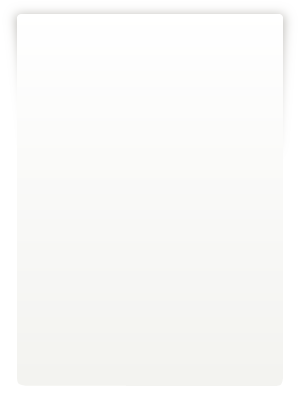
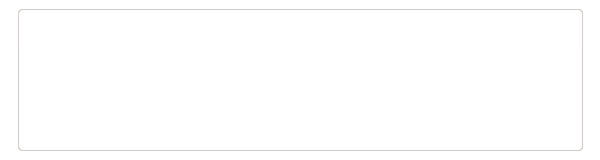
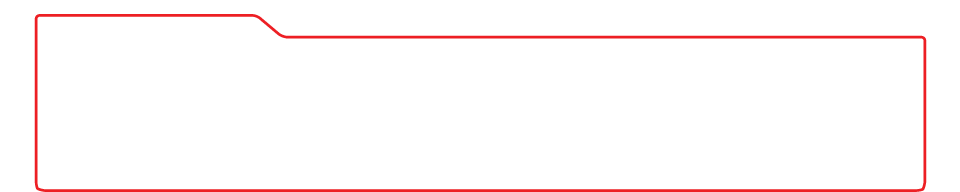
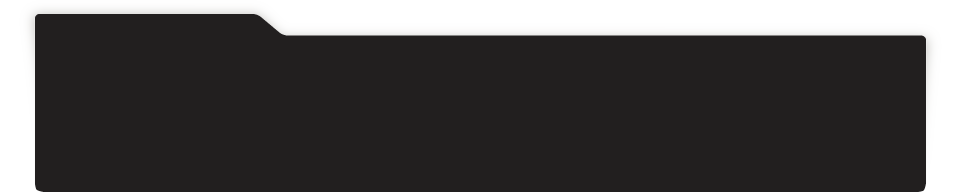
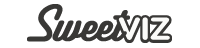
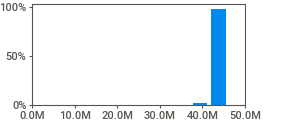
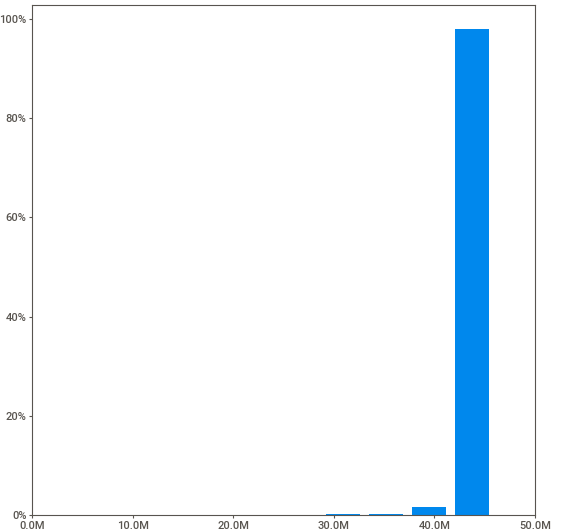
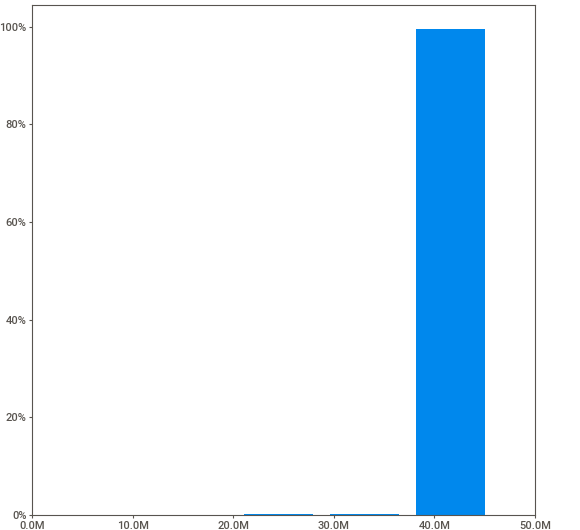
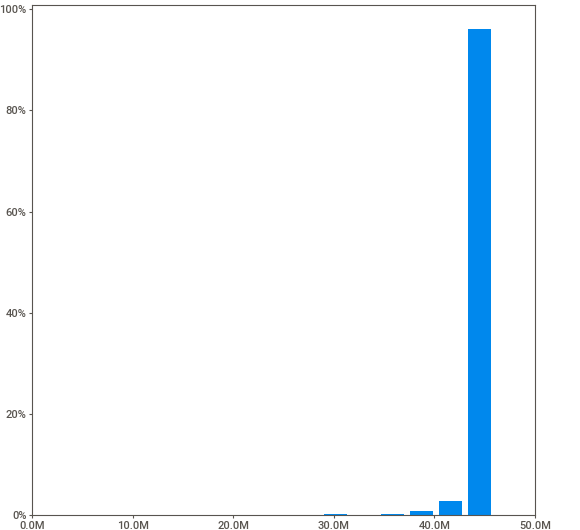
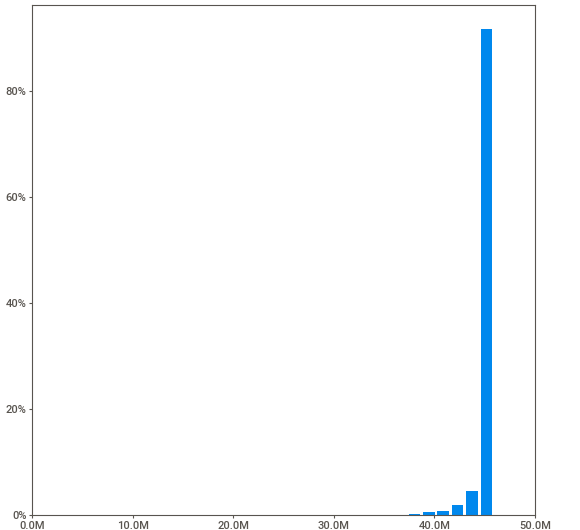
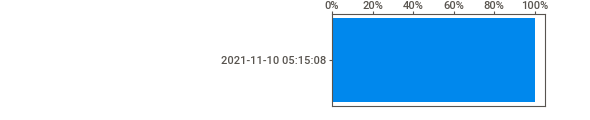
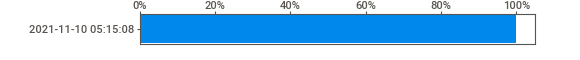
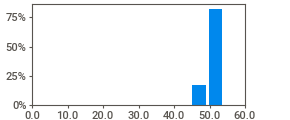
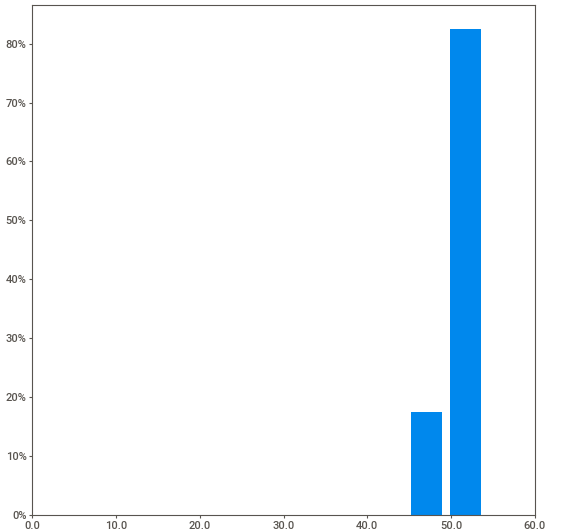
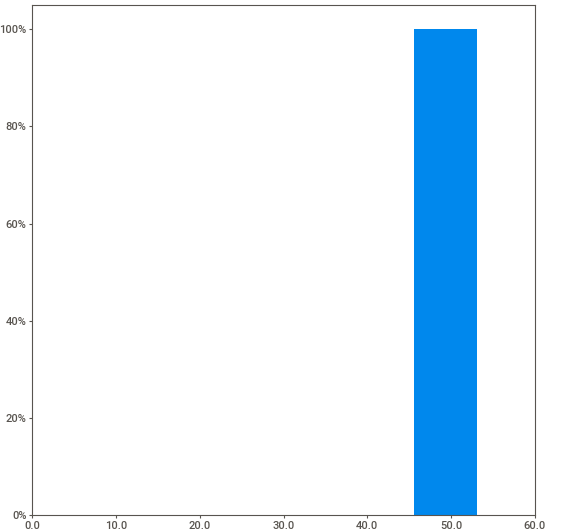
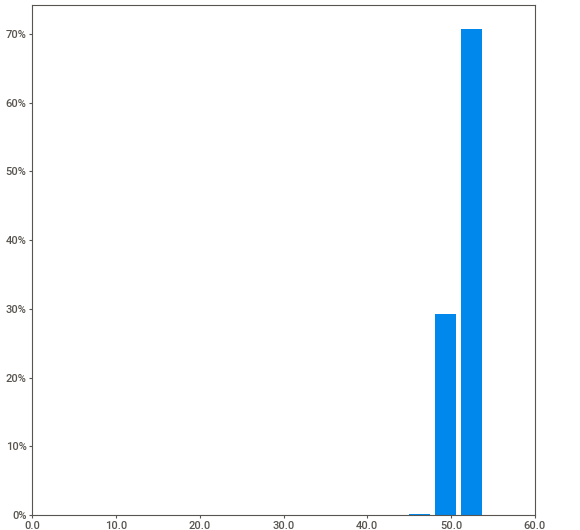
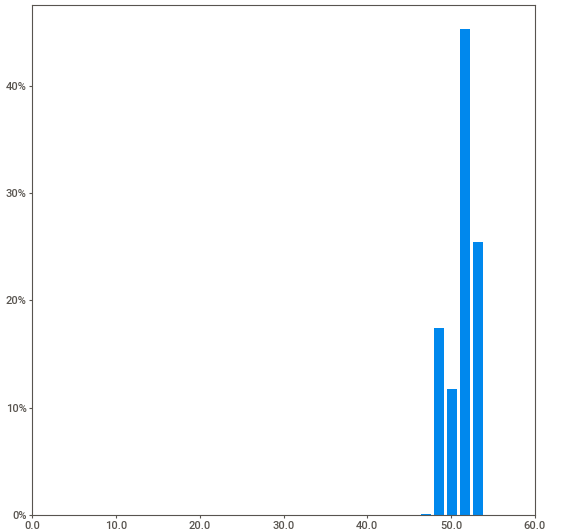
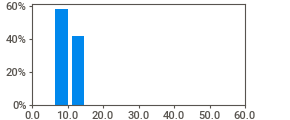
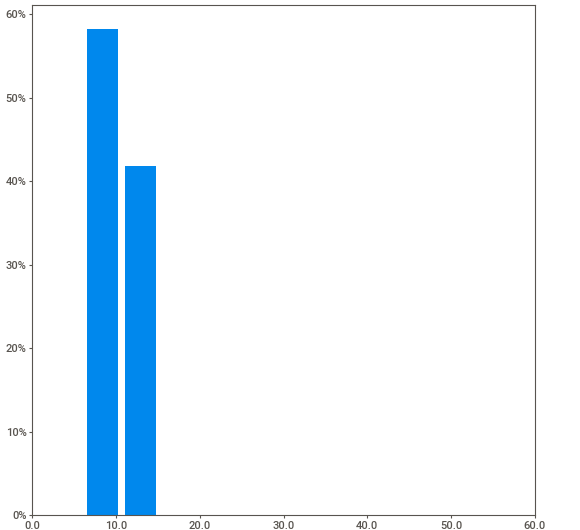
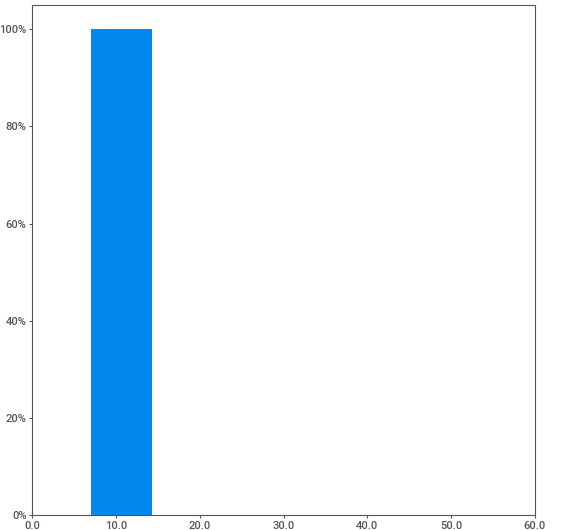
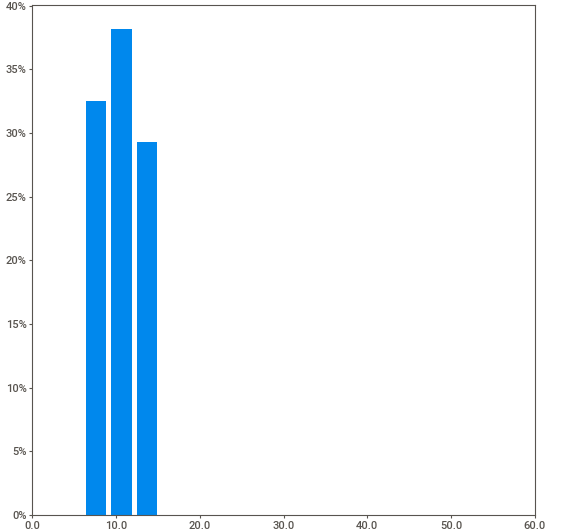
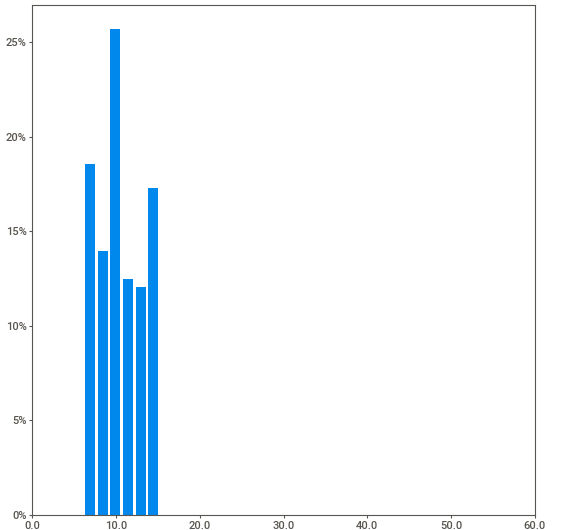
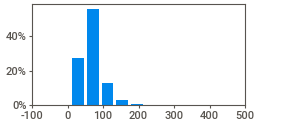
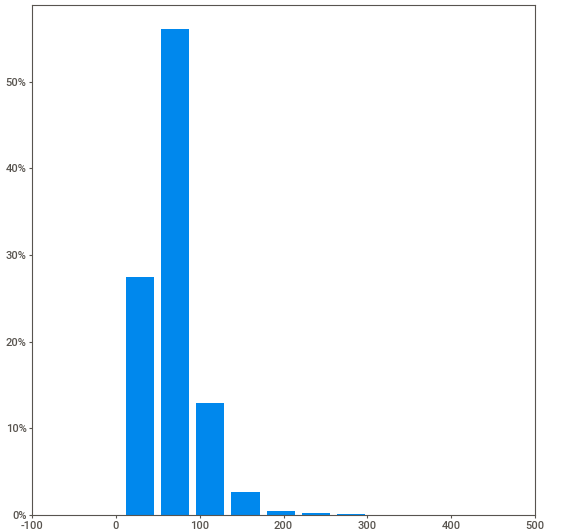
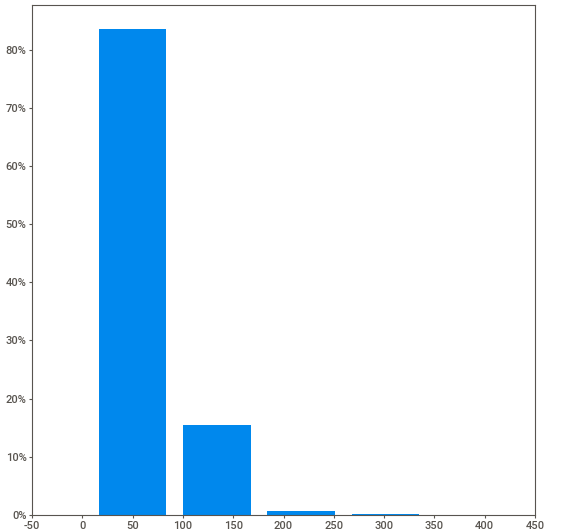
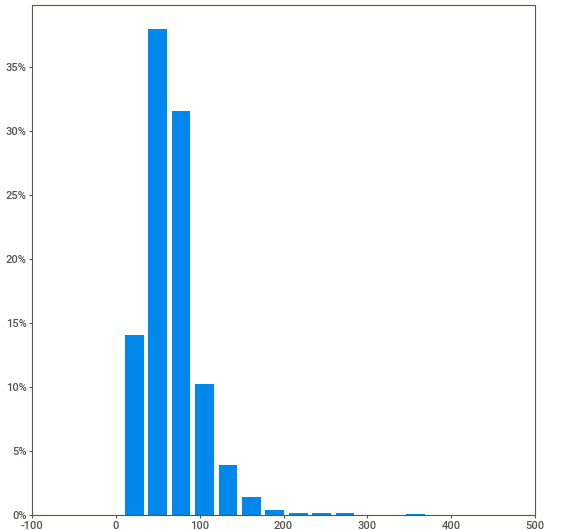
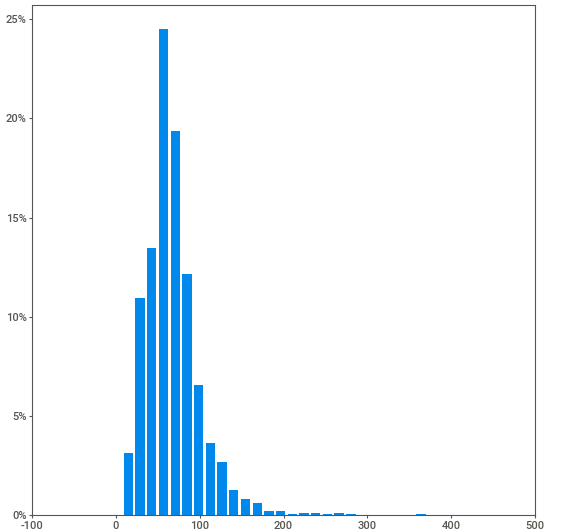
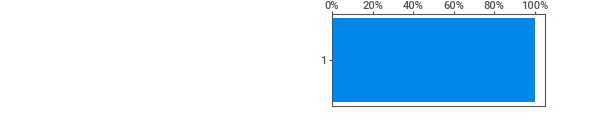
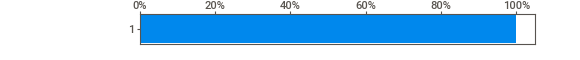
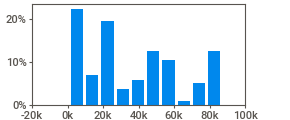
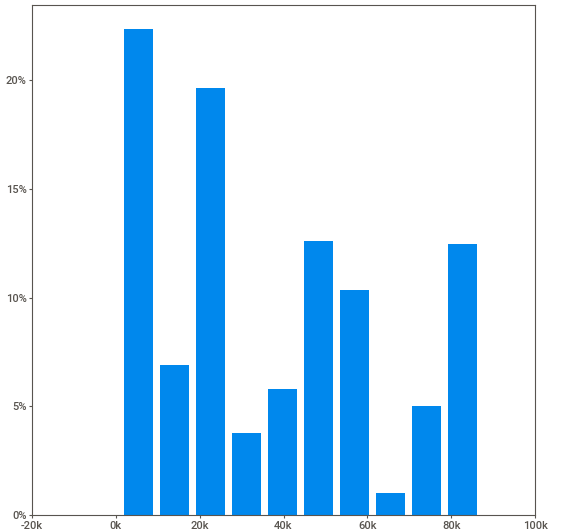
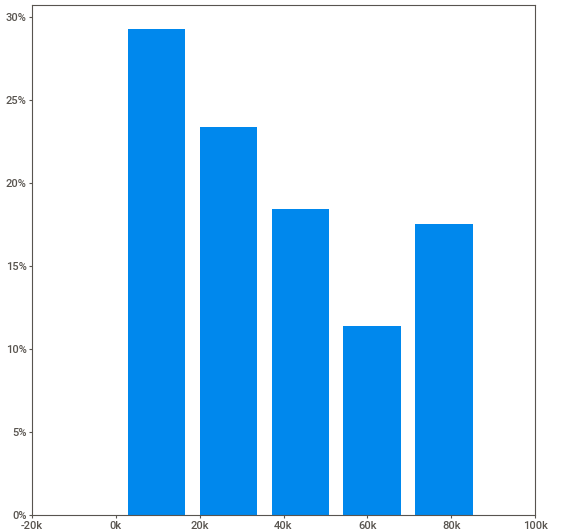
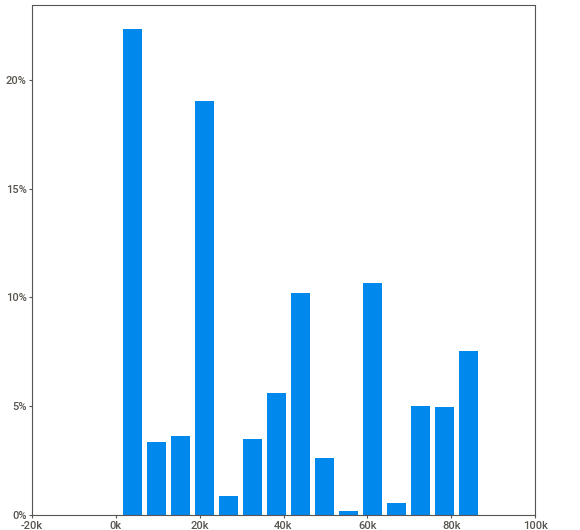
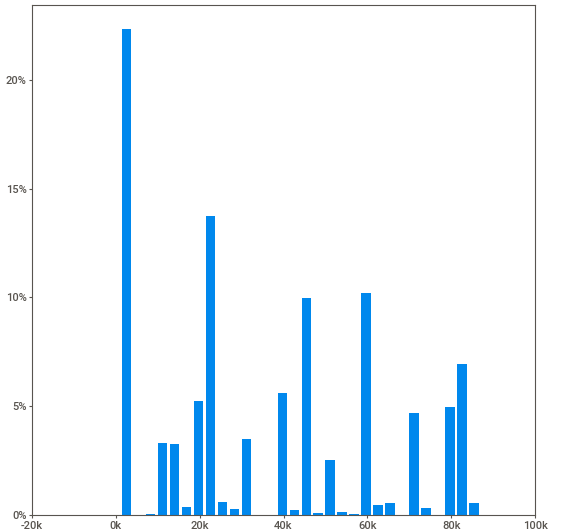
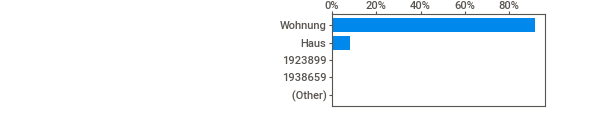
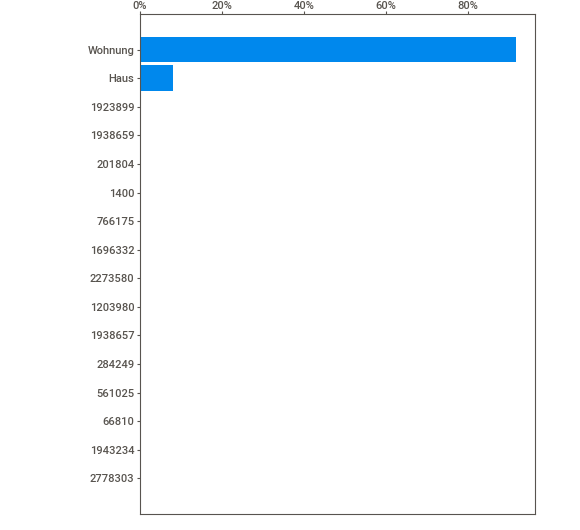
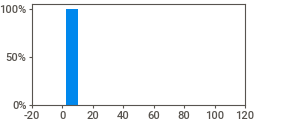
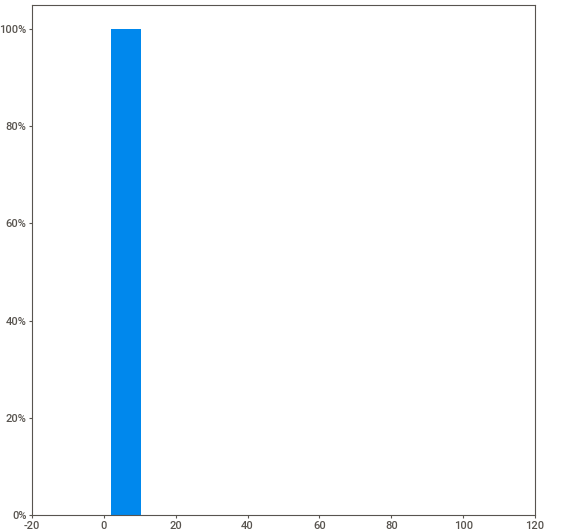
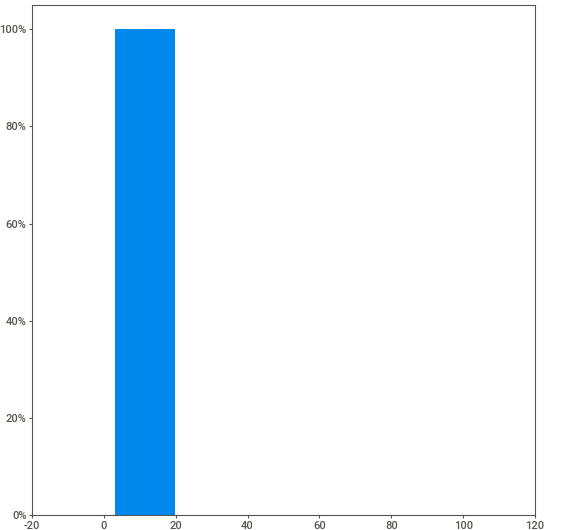
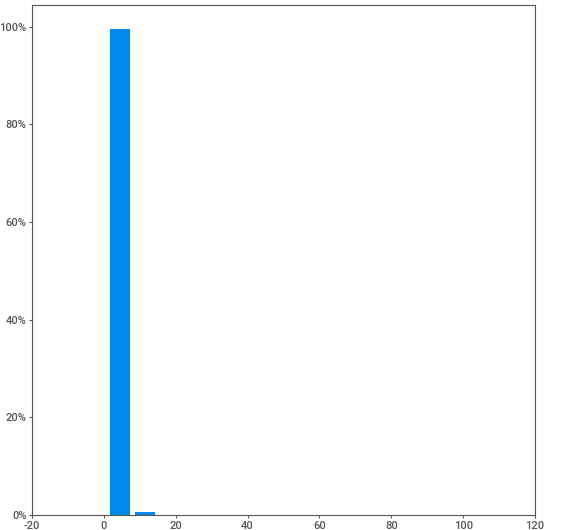
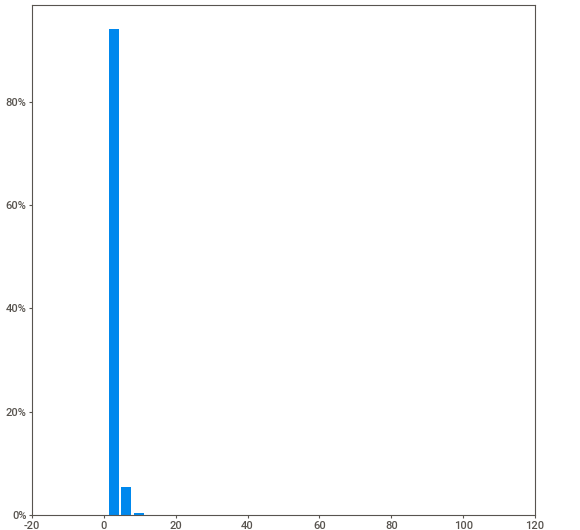
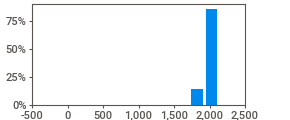
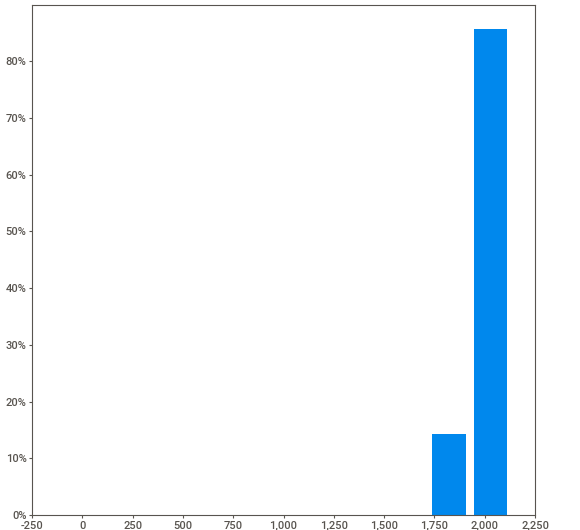
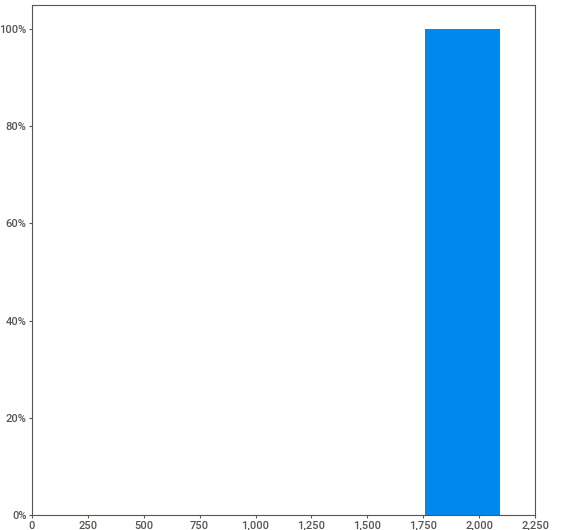
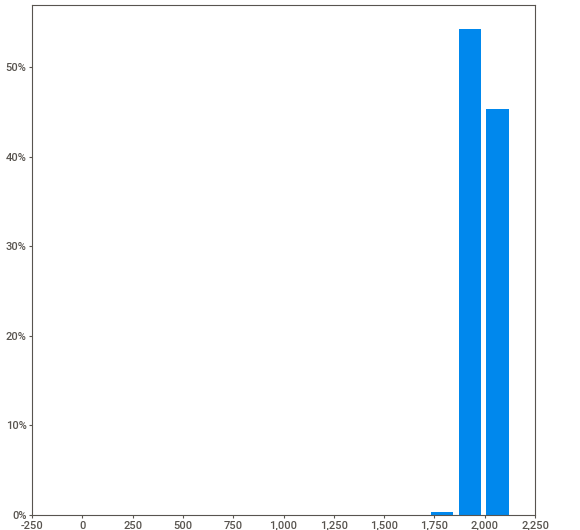
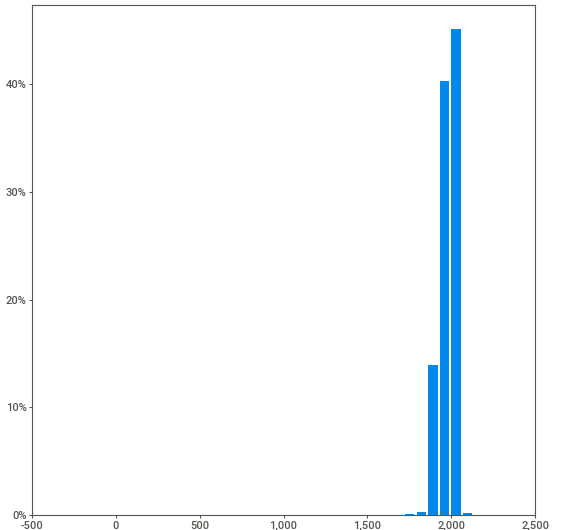
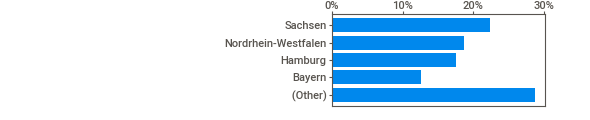
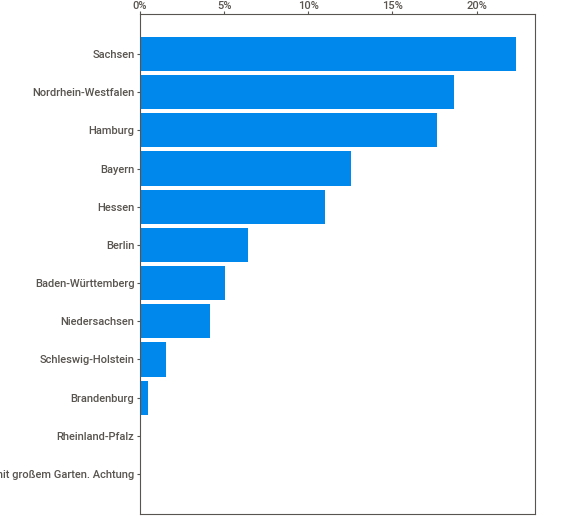
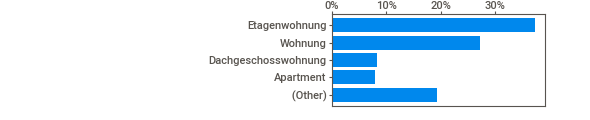
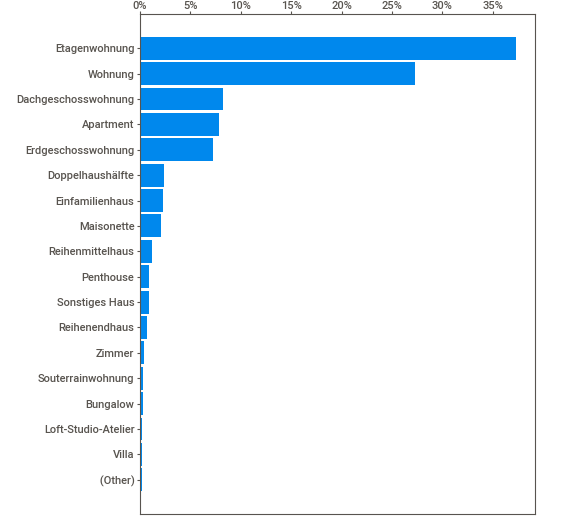
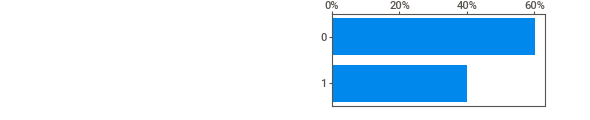
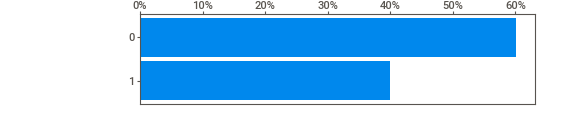
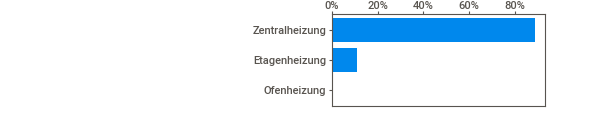
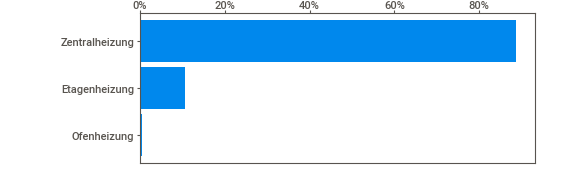
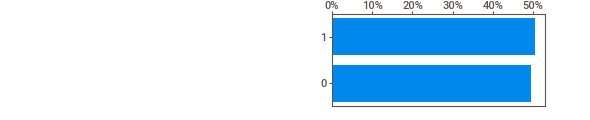
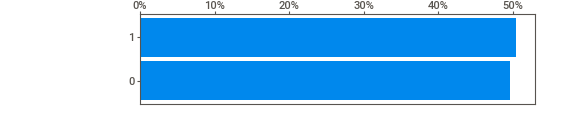
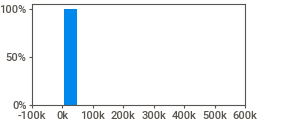
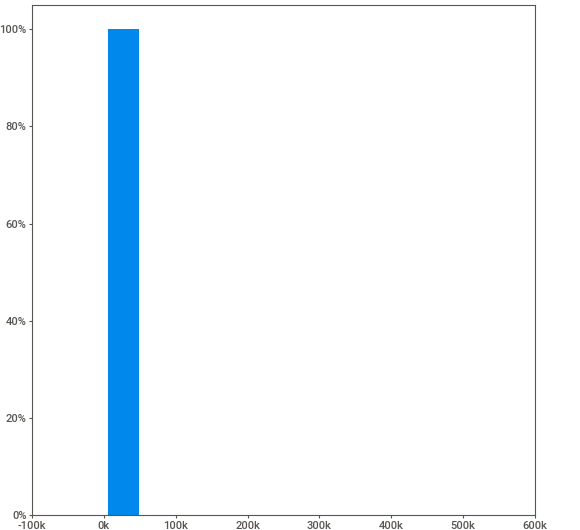
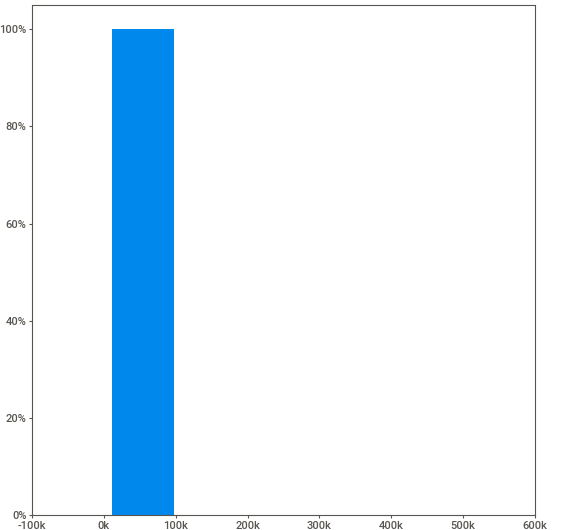
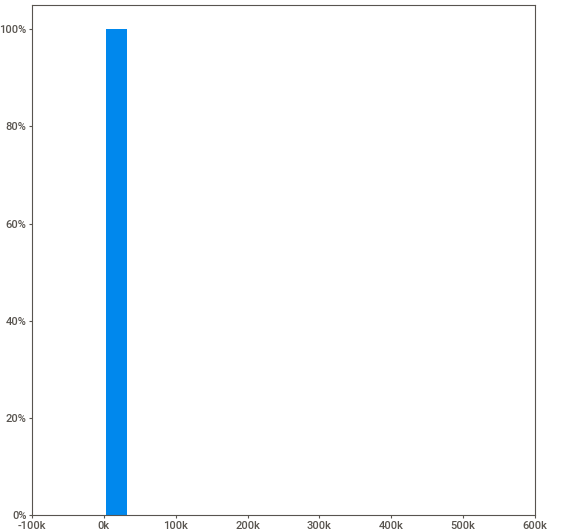
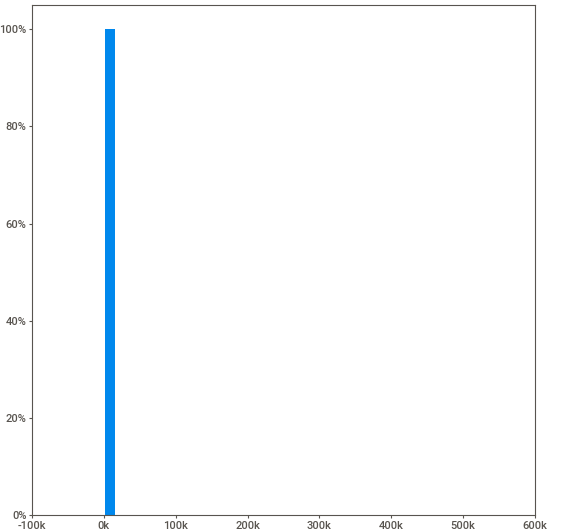
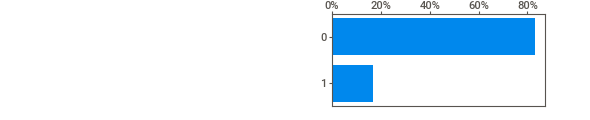
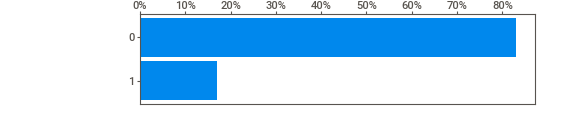
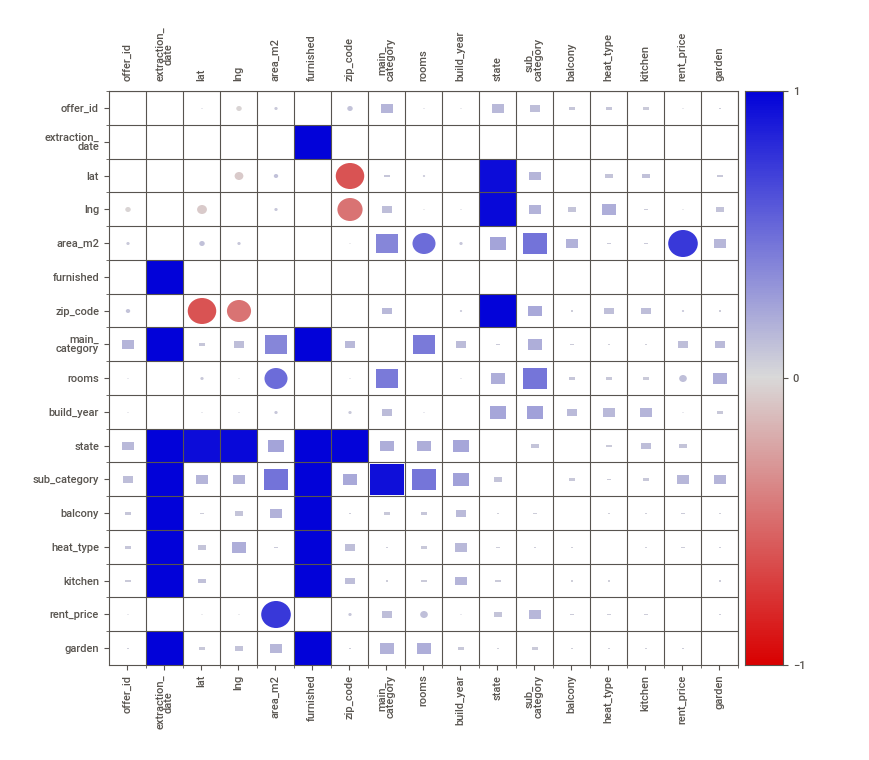
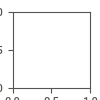

In [33]:
analysis = sv.analyze(df)
analysis.show_notebook()

In [34]:
# remove NaN rows from rent_price - our main information can not have NaN values.

df.dropna(subset=['rent_price'], inplace=True)

## EDA

### Main Hypotheses

1. Offers with larger areas are more expensive.
2. The more rooms, the more expensive.
3. Offers with garten are more expensive.
4. Offers with pre-installed kitchens are more expensive.
5. Offers in old buildings are less expensive.
6. Offers with balcony are more expensive.

#### 1. Offers with larger areas are more expensive.

In [35]:
# Strategy: group the areas by a range and compare them by average rent price.

df['area_m2'].describe()

count    6028.000000
mean       67.360612
std        33.190757
min         8.000000
25%        47.315000
50%        62.310000
75%        80.925000
max       427.000000
Name: area_m2, dtype: float64

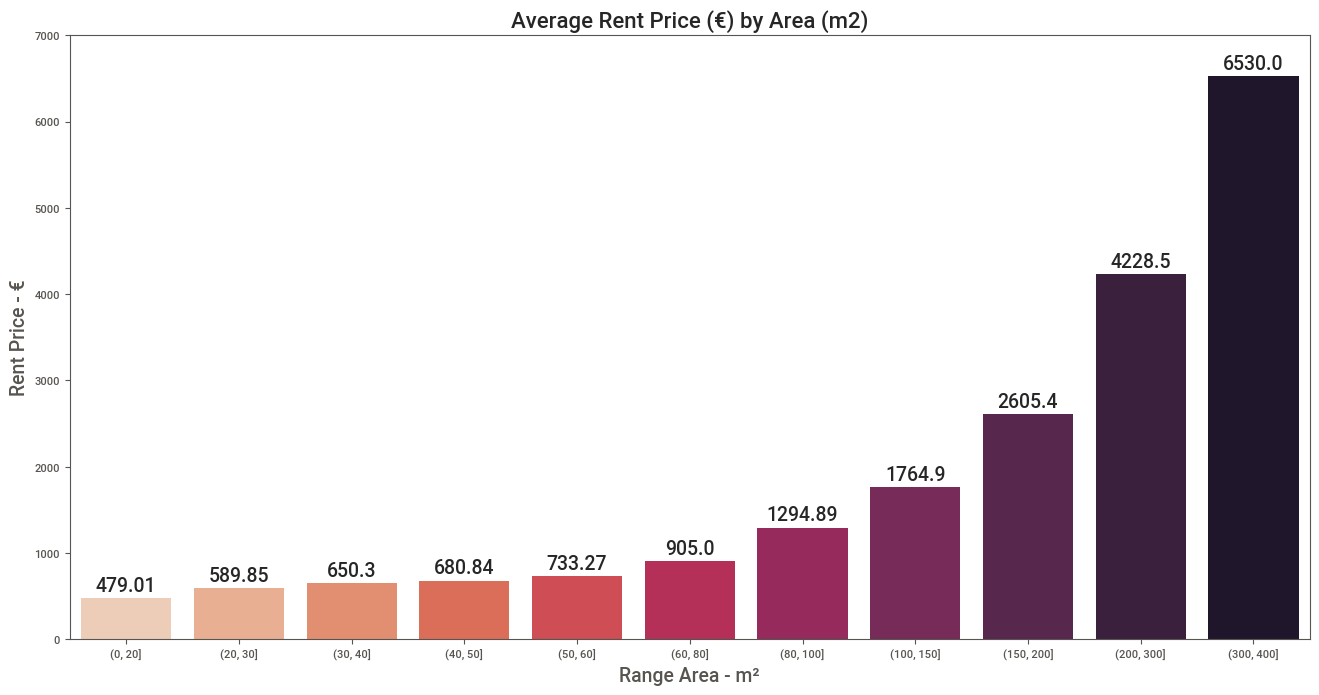

In [36]:
# create a auxiliar dataframe to aggregate the needed infos
df_aux = df[['area_m2', 'rent_price']]
df_aux['range_area'] = pd.cut(df_aux['area_m2'], [0, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300, 400])
df_aux2 = pd.DataFrame(df_aux.groupby('range_area')['rent_price'].mean().round(2)).reset_index()

# plot the infos
ax = sns.barplot(x=df_aux2['range_area'], y=df_aux2['rent_price'], palette="rocket_r")
ax.set_title('Average Rent Price (€) by Area (m2)', fontsize=16)
ax.set_ylabel('Rent Price - €', fontsize=14)
ax.set_xlabel('Range Area - m²', fontsize=14)
ax.set(ylim=(0, 7000))
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_m2.png')

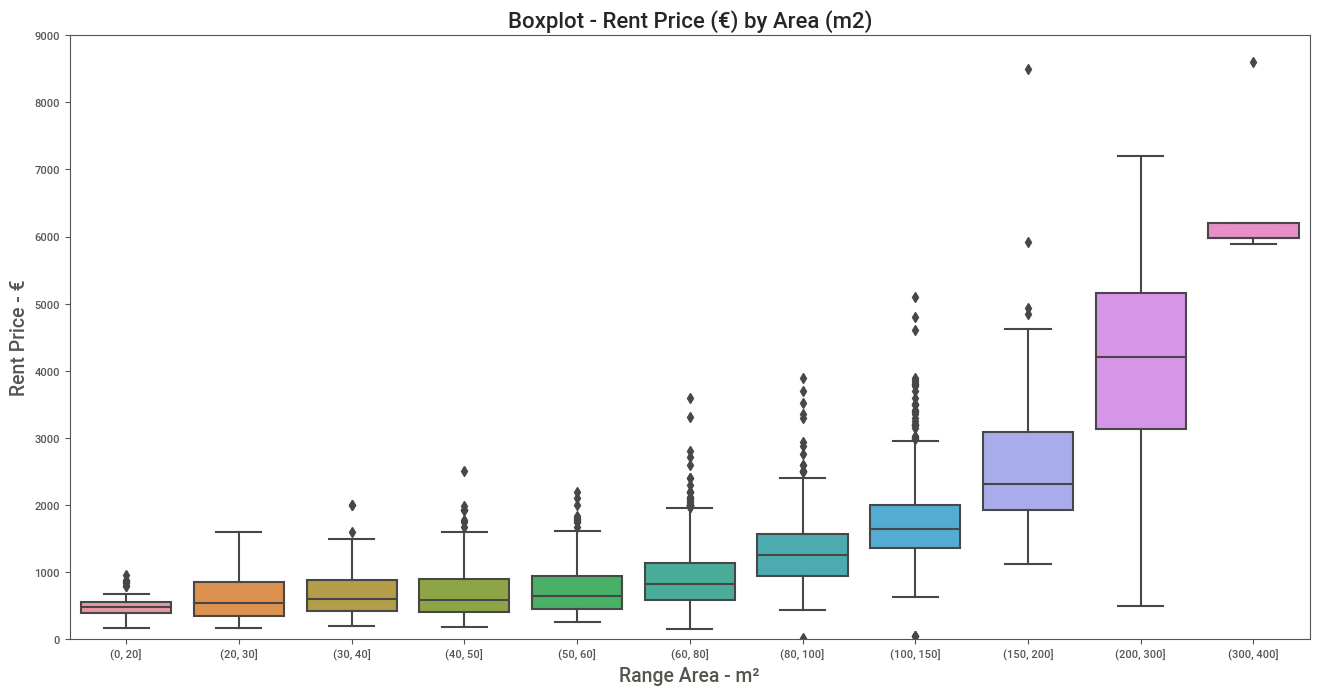

In [37]:
# boxplot
ax = sns.boxplot(x=df_aux['range_area'], y=df_aux['rent_price'])
ax.set_title('Boxplot - Rent Price (€) by Area (m2)', fontsize=16)
ax.set_ylabel('Rent Price - €', fontsize=14)
ax.set_xlabel('Range Area - m²', fontsize=14)
ax.set(ylim=(0, 9000))
plt.savefig('../charts/boxplot_rent_by_m2.png')

**HYPOTESIS 01 - True**

As expected, offers with larger areas are more expensive, at least when we refer to absolute values.

#### 02. The more rooms, the more expensive.

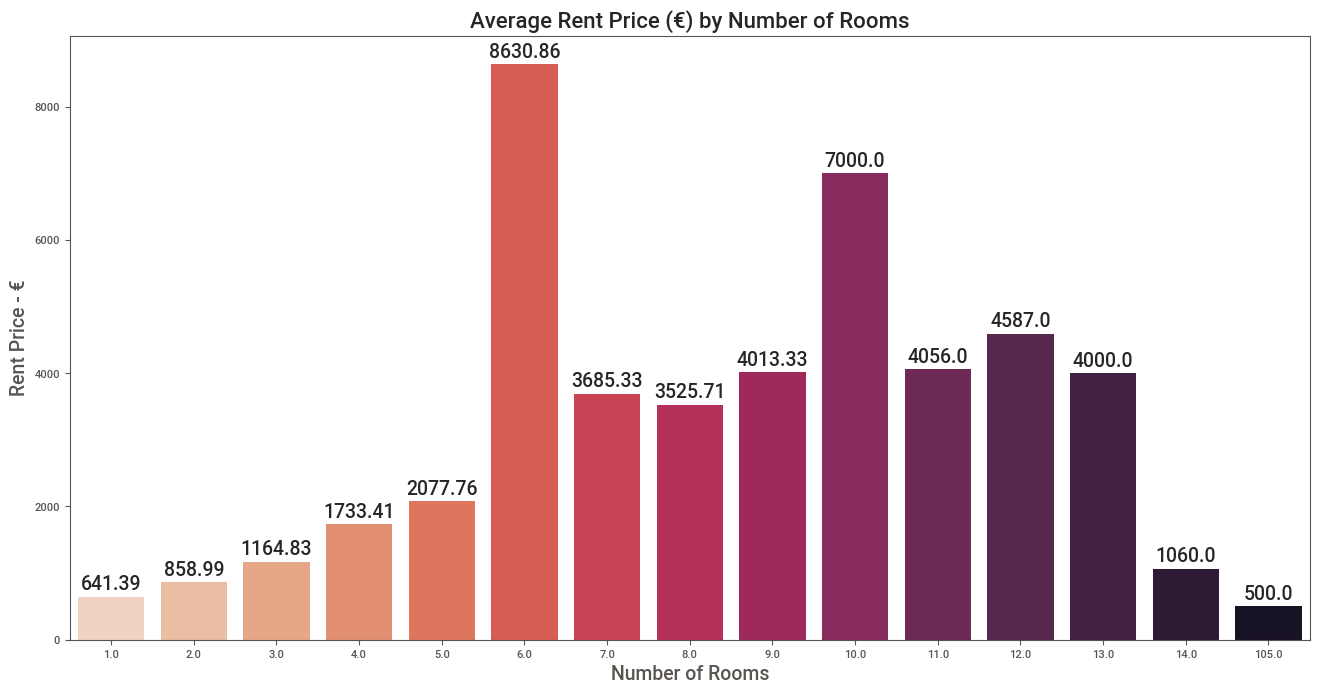

In [40]:
# create a auxiliar dataframe grouped by number of rooms
df_aux = df[df['rooms'] != NaN]
df_aux = pd.DataFrame(df.groupby('rooms')['rent_price'].mean().round(2)).reset_index()

# plot the infos
ax = sns.barplot(x=df_aux['rooms'], y=df_aux['rent_price'], palette="rocket_r")
ax.set_title('Average Rent Price (€) by Number of Rooms', fontsize=16)
ax.set_ylabel('Rent Price - €', fontsize=14)
ax.set_xlabel('Number of Rooms', fontsize=14)
#ax.set(ylim=(0, 8000))
annot_plot(ax)
plt.savefig('../charts/avg_rent_by_rooms.png')

In [41]:
# 105 room with a average rent_price == 500?

df[df['rooms'] > 30]

,offer_id,extraction_date,lat,lng,area_m2,furnished,zip_code,main_category,rooms,build_year,state,city,sub_category,balcony,heat_type,offer_title,kitchen,rent_price,garden
1731,44311674,2021-11-10 05:15:08,51.4601,7.00878,20.0,1,45127.0,Wohnung,105.0,2020.0,Nordrhein-Westfalen,Essen,Apartment,1,Zentralheizung,105-Zimmer-Wohnung in Essen zu vermieten,1,500.0,0


#### 3. Offers with garten are more expensive.

#### 4. Offers with pre-installed kitchens are more expensive.

#### 5. Offers in old buildings are less expensive.

#### 6. Offers with balcony are more expensive.

### Search for insights

- Check the rent price distributions.
- Check average rent price for each city.
- Check price/m2 for each city.
- Check price/m2 for each zip code.
- Check average price per years build.
- Check average price by state.
- Check average price by room.
- Check average price by sub-category.
- Check average price by heat type.

#### Rent price distributions

<AxesSubplot:xlabel='area_m2', ylabel='rent_price'>

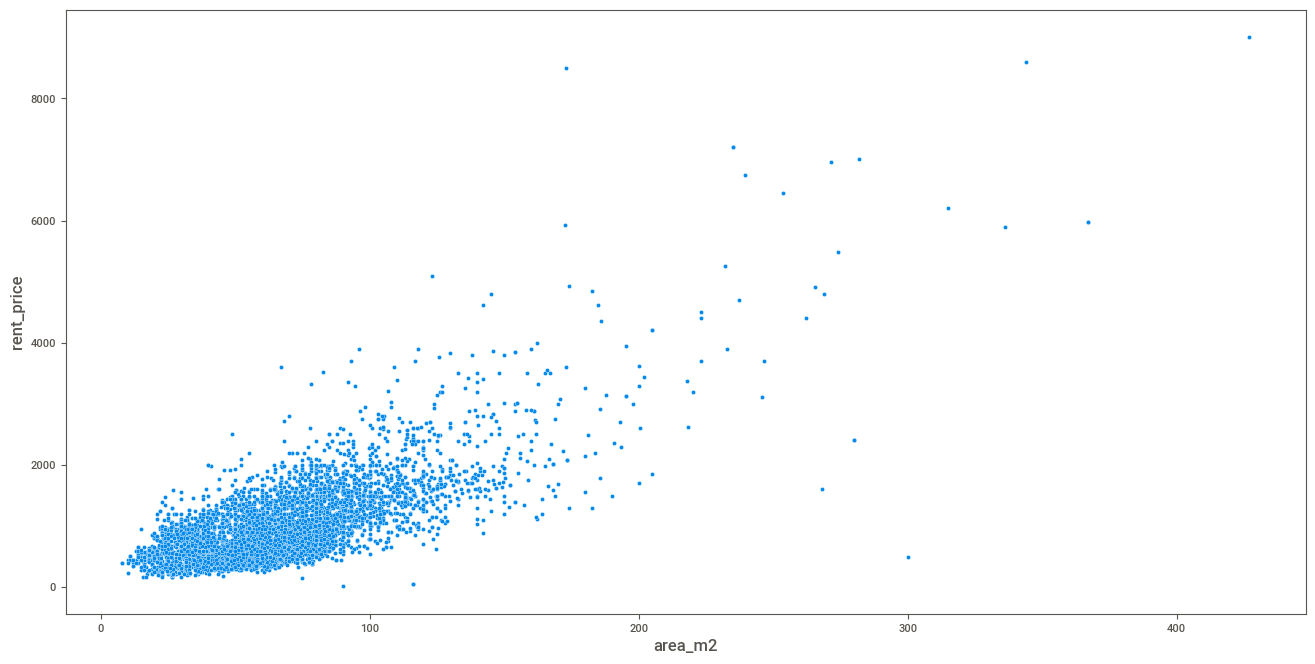

In [42]:
# Rent price X Area
sns.scatterplot(x=df['area_m2'], y=df['rent_price'])